In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from utils import important_channels
import utils
from sklearn.linear_model import LinearRegression

In [2]:
raw_data = pd.read_csv('data/train/Data_S06_Sess01.csv')
feedback_times = raw_data[raw_data['FeedBackEvent'] == 1]['Time']
feedback_indices = feedback_times.index
fs = 200 # sampling frequency
default_channel = important_channels[0] # channel Cz

In [42]:
print(f'Feedback Times: \n{feedback_times}')
print(f'Feedback Indices: \n{feedback_indices}')
print(f'Column names: \n{raw_data.columns}')

Feedback Times: 
4214       21.070
5908       29.540
7591       37.955
9268       46.340
10951      54.755
14155      70.775
16388      81.940
18628      93.140
20845     104.225
23085     115.425
25718     128.590
27398     136.990
29078     145.390
30748     153.740
32415     162.075
35612     178.060
37849     189.245
40072     200.360
42312     211.560
44555     222.775
47216     236.080
48889     244.445
50566     252.830
52252     261.260
53936     269.680
56576     282.880
58262     291.310
59956     299.780
61639     308.195
63319     316.595
66536     332.680
68776     343.880
71013     355.065
73253     366.265
75470     377.350
78680     393.400
80940     404.700
83200     416.000
85437     427.185
87680     438.400
90320     451.600
91997     459.985
93680     468.400
95360     476.800
97033     485.165
99677     498.385
101357    506.785
103030    515.150
104720    523.600
106397    531.985
109577    547.885
111817    559.085
114041    570.205
116281    581.405
118524    5

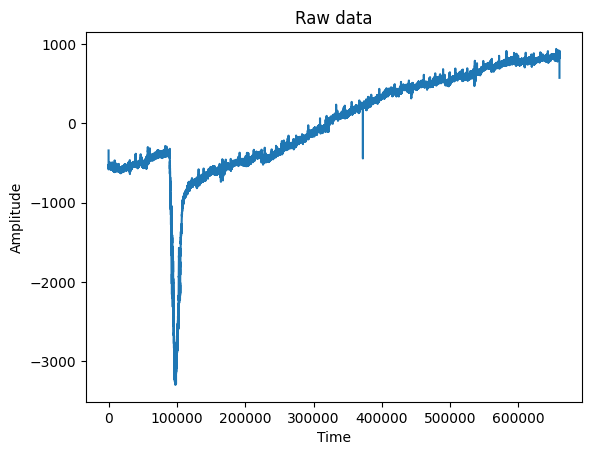

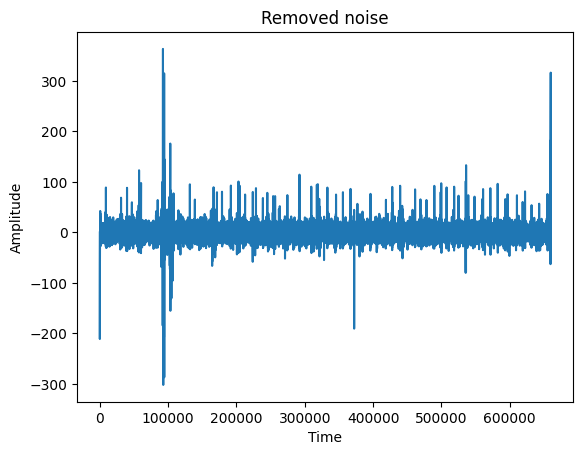

0          -0.053806
1        -105.988905
2        -180.806933
3        -211.092407
4        -206.037066
             ...    
131996    294.200442
131997    316.333843
131998    283.782546
131999    182.466744
132000     33.210205
Name: Cz, Length: 132001, dtype: float64


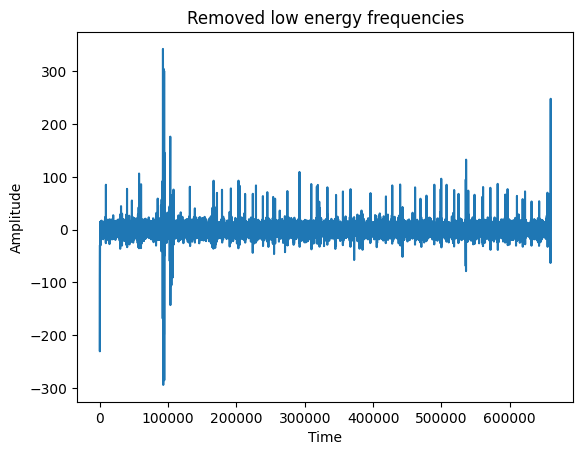

In [4]:
utils.plot_channel(raw_data, 0, default_channel, title='Raw data')

temp = utils.bandpass_filter_all(raw_data, highcut=30)
utils.plot_channel(temp, 0, default_channel, title='Removed noise')
print(temp[default_channel])
filtered_data = utils.bandpass_filter_all(temp, lowcut=0.2, highcut=10)
utils.plot_channel(filtered_data, 0, default_channel, title='Removed low energy frequencies')

In [21]:
proc_channels = filtered_data[important_channels]
print(proc_channels.shape)
data_arr = proc_channels.to_numpy().T
print(f'Data numpy array size: \t{data_arr.shape}')
eog_data = filtered_data['EOG'].to_numpy()
print(f'EOG array size: \t{eog_data.shape}')
eog_data = utils.bandpass_filter_arr(eog_data, highcut=30)

def remove_eog_artifacts(eeg_data, eog_signal):
    eeg_cleaned = np.zeros_like(eeg_data)
    for i in range(eeg_data.shape[0]):
        reg = LinearRegression().fit(eog_signal.reshape(-1, 1), eeg_data[i, :])
        predicted_artifact = reg.predict(eog_signal.reshape(-1, 1))
        eeg_cleaned[i, :] = eeg_data[i, :] - predicted_artifact
    return eeg_cleaned

eeg_cleaned = remove_eog_artifacts(data_arr, eog_data)
print(f'EEG cleaned size: \t{eeg_cleaned.shape}')

(132001, 16)
Data numpy array size: 	(16, 132001)
EOG array size: 	(132001,)
EEG cleaned size: 	(16, 132001)


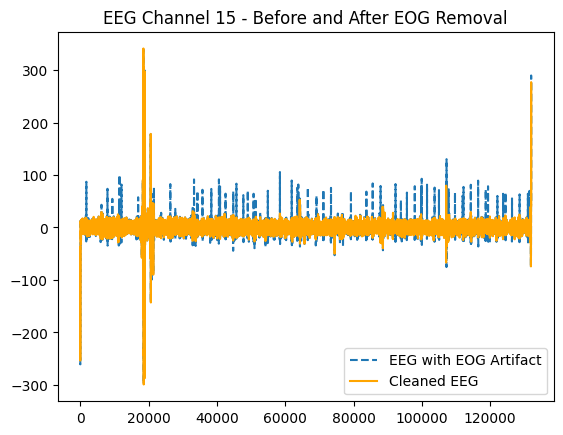

In [27]:
channel = 15
plt.plot(filtered_data[important_channels[channel]], label="EEG with EOG Artifact", linestyle="dashed")
plt.title(f"EEG Channel {channel} - Before and After EOG Removal")
plt.plot(eeg_cleaned[channel], label="Cleaned EEG", color="orange")
plt.legend()
plt.show()

In [63]:
def get_arr_after_feedback(eeg_cleaned, feedback_id=0, before=0.2, after=1.3, fs=200):
    t_index = feedback_indices[feedback_id]
    t = raw_data['Time'][t_index]
    start_idx = int((t - before) * fs)
    end_idx = int((t + after) * fs) + 1
    time = raw_data['Time'][start_idx:end_idx]
    print(f'Feedback index:\t{t_index}')
    print(f'Start index: \t{start_idx}')
    print(f'End index: \t{end_idx}')
    print(f'Length: \t{len(time.to_numpy())}')
    return eeg_cleaned[:, start_idx:end_idx], (time.to_numpy() - t) * 1000

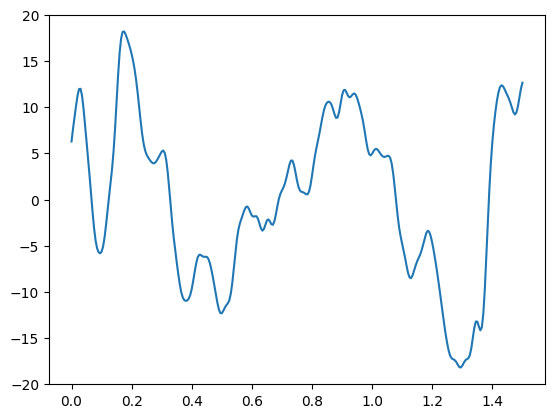

Feedback index:	66536
Start index: 	66496
End index: 	66797
Length: 	301


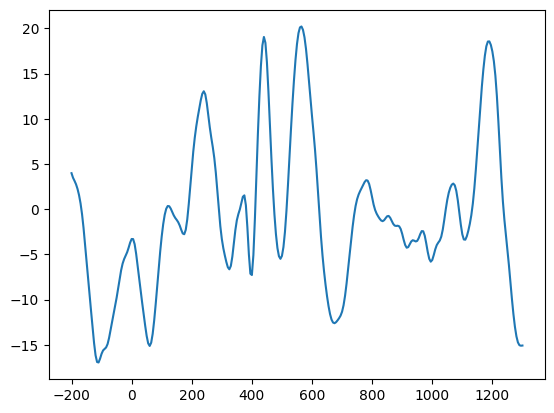

In [66]:
# also check a random part of the data
start_idx = 60000
end_idx = 60301
plt.plot(raw_data['Time'][start_idx:end_idx].to_numpy() - (start_idx/fs), eeg_cleaned[0, start_idx:end_idx])
plt.show()

eeg_part, time = get_arr_after_feedback(eeg_cleaned, feedback_id=30)
plt.plot(time, eeg_part[0])
plt.show()

301


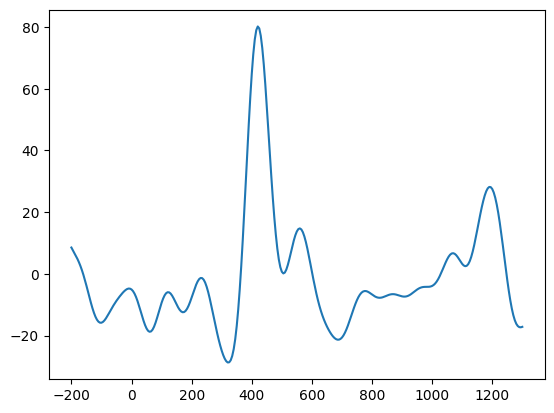

In [67]:
feedback_id = 30
part, t = utils.get_part_after_feedback(filtered_data, feedback_times, feedback_id=feedback_id, before=0.2, after=1.3)
time = (part['Time'] - t) * 1000
print(len(time))
'''for i in range(len(important_channels)):
    plt.plot(time, part[important_channels[i]])
'''
plt.plot(time, part[default_channel])
plt.show()

[14.74289616 28.1764726 ] 80.17201728013947
Latency: 0.42s


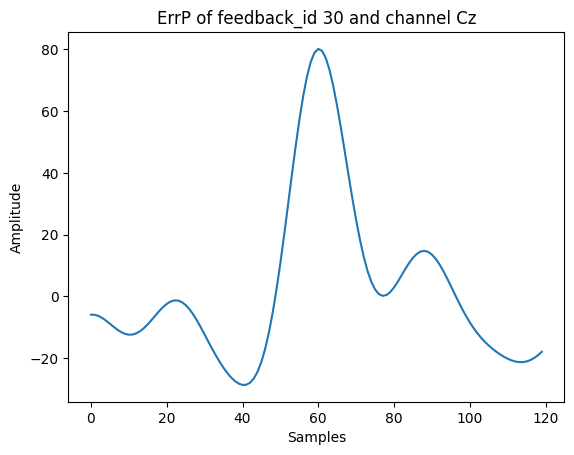

In [68]:
# The criterion is stricter when n is lower and threshold higher
# 'n' is the maximum number of peaks that can be higher than the threshold
# 'threshold' is the ratio of the peak value to the max peak value
# 'lat_fix' should be equal to 'before' parameter of get_part_after_feedback function
def find_errp(np_signal, n=5, threshold=0.5, verbose=False, before=0.3, after=0.3, fs=200, lat_fix=0.2):
    peaks, _ = find_peaks(np_signal)
    peak_values = np_signal[peaks]
    peak_values = peak_values[peak_values > 0]

    max_peak = np.max(peak_values)
    peak_values = peak_values[peak_values != max_peak] # remove the max peak
    peak_values.sort() # sort peaks in ascending order
    peak_values = peak_values[-n:]
    if verbose: print(peak_values, max_peak)
    
    times = 0
    for v in peak_values:
        if (v / max_peak) >= threshold:
            times += 1

    peak_index = np.argmax(np_signal)
    T = 1/fs
    before_samples = int(before/T)
    after_samples = int(after/T) 

    latency = peak_index * T - lat_fix
    if verbose: print(f'Latency: {latency}s')

    return times < n, np_signal[peak_index - before_samples:peak_index + after_samples], latency

check, errp, _ = find_errp(part[default_channel].to_numpy(), n=2, threshold=0.7, verbose=True)
if check: utils.plot_signal(errp, title=f'ErrP of feedback_id {feedback_id} and channel {default_channel}')

In [69]:
N = len(feedback_times)

def calc_accuracy(n, threshold, verbose=True):
    counter = 0
    for i in range(N):
        part, _ = utils.get_part_after_feedback(filtered_data, feedback_times, feedback_id=i, before=0.2, after=1.3)
        check, _, _ = find_errp(part[default_channel].to_numpy(), n=2, threshold=0.7)
        if check: counter += 1
    accuracy = counter/N
    if verbose: print(f'Accuracy: {accuracy*100}% ({counter}/{N})')
    return accuracy

calc_accuracy(2, 0.7)

Accuracy: 85.0% (51/60)


0.85

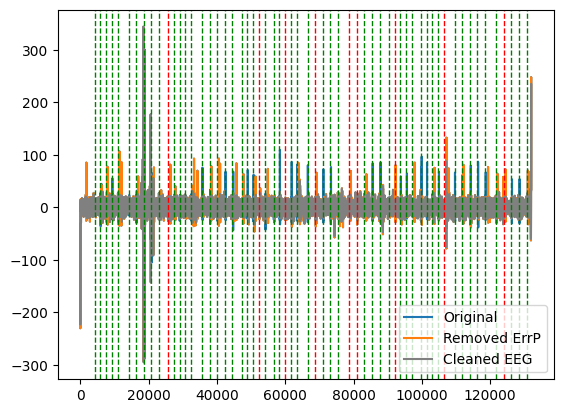

In [72]:
removed_errp = filtered_data.copy()
errp_indices = []
for i in range(N):
    part, t = utils.get_part_after_feedback(filtered_data, feedback_times, feedback_id=i, before=0.2, after=1.3)
    check, errp, lat = find_errp(part[default_channel].to_numpy(), n=2, threshold=0.7)
    if check:
        #print(t, int(t*fs))
        removed_errp.loc[int(t*fs):int(t*fs)+len(part), default_channel] = 0
        errp_indices.append(i)

plt.plot(filtered_data[default_channel])
plt.plot(removed_errp[default_channel])
plt.plot(eeg_cleaned[0], color='gray')
counter = 0
c = 'r'
for x_line in feedback_indices:
    if counter in errp_indices:
        c = 'g'
    else:
        c = 'r'
    plt.axvline(x=x_line, color=c, linestyle='--', linewidth=1, label=f"x={x_line}" if x_line == feedback_indices[0] else "")
    counter += 1

plt.legend(['Original', 'Removed ErrP', 'Cleaned EEG'])
plt.show()